<a href="https://colab.research.google.com/github/ZHBIT92/colob_project/blob/master/%E5%85%89%E6%B5%81%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pySTEPS/pysteps
!pip install pyproj

  Cloning https://github.com/pySTEPS/pysteps to /tmp/pip-req-build-c36f3801
  Running command git clone -q https://github.com/pySTEPS/pysteps /tmp/pip-req-build-c36f3801
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Processing /root/.cache/pip/wheels/64/f4/de/9667d84f759289edf5442220997c6d4334637a6bb2a7b90f73/jsmin-2.2.2-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ef/97/28fe7e68bc7adfce67d4339756e85e9fcf3c6fd7f0c0781695352b70472c/attrdict-2.0.1-py2.py3-none-any.whl
  Created wheel for pysteps: filename=pysteps-1.2.0-cp36-cp36m-linux_x86_64.whl size=975120 sha256=5827ee413a5cf039398d4db642194a96ba78b150e6b8f95c99a493fef6be1b28
  Stored in directory: /tmp/pip-ephem-wheel-cache-_loacgql/wheels/22/e9/c0/c19c043836ff5fbe1697cb0a0a4d328b8a6d85cf552cb50f5d
Successfully built pysteps
     |████████████████████████████████| 10.4MB 106kB/s 


In [2]:
import pysteps
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

from pysteps import io, motion, nowcasts, rcparams, verification
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver

Pysteps configuration file found at: /usr/local/lib/python3.6/dist-packages/pysteps/pystepsrc



In [3]:
# Selected case
date = datetime.strptime("201505151630", "%Y%m%d%H%M")
print(date)
data_source = rcparams.data_sources["mch"]
n_leadtimes = 12
print(data_source)

2015-05-15 16:30:00
AttrDict({'root_path': './radar/mch', 'path_fmt': '%Y%m%d', 'fn_pattern': 'AQC%y%j%H%M?_00005.801', 'fn_ext': 'gif', 'importer': 'mch_gif', 'timestep': 5, 'importer_kwargs': {'product': 'AQC', 'unit': 'mm', 'accutime': 5}})


In [4]:
#从归档中加载数据
root_path = data_source["root_path"]
root_path = '/content/drive/My Drive/radar_data/mch/'
print(root_path)

path_fmt = data_source["path_fmt"]
path_fmt =  '20150515'
print(path_fmt)

fn_pattern = data_source["fn_pattern"]
fn_pattern = 'AQC151351545F_00005.801'
print(fn_pattern)

fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]
timestep = data_source["timestep"]

/content/drive/My Drive/radar_data/mch/
20150515
AQC151351545F_00005.801


In [0]:
# Find the input files from the archive
fns = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep=5, num_prev_files=9
)

In [0]:
# Read the radar composites
importer = io.get_method(importer_name, "importer")
R, quality, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

del quality  # Not used

预处理的数据

In [7]:
# Convert to mm/h
R, metadata = conversion.to_rainrate(R, metadata)

# Store the reference frame
R_ = R[-1, :, :].copy()

# Log-transform the data [dBR]
R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

# Nicely print the metadata
pprint(metadata)

{'accutime': 5,
 'institution': 'MeteoSwiss',
 'product': 'AQC',
 'projection': '+proj=somerc  +lon_0=7.43958333333333 +lat_0=46.9524055555556 '
               '+k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel '
               '+towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'threshold': -10.0,
 'timestamps': array([datetime.datetime(2015, 5, 15, 15, 45),
       datetime.datetime(2015, 5, 15, 15, 50),
       datetime.datetime(2015, 5, 15, 15, 55),
       datetime.datetime(2015, 5, 15, 16, 0),
       datetime.datetime(2015, 5, 15, 16, 5),
       datetime.datetime(2015, 5, 15, 16, 10),
       datetime.datetime(2015, 5, 15, 16, 15),
       datetime.datetime(2015, 5, 15, 16, 20),
       datetime.datetime(2015, 5, 15, 16, 25),
       datetime.datetime(2015, 5, 15, 16, 30)], dtype=object),
 'transform': 'dB',
 'unit': 'mm/h',
 'x1': 255000.0,
 'x2': 965000.0,
 'xpixelsize': 1000.0,
 'y1': -160000.0,
 'y2': 480000.0,
 'yorigin': 'upper',
 'ypixelsize': 1000.0,
 'zerovalue': -15.0,
 '

###卢卡斯-卡纳德（LK）
pysteps中实现的Lucas-Kanade光流方法是一种依赖于OpenCV软件包的本地跟踪方法。在两个或多个雷达图像序列中跟踪局部特征。该方案包括最后的插值步骤，以便产生运动矢量的平滑场。

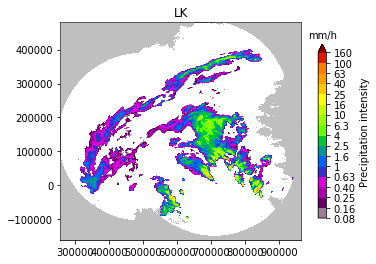

In [8]:
oflow_method = motion.get_method("LK")
V1 = oflow_method(R[-3:, :, :])

# Plot the motion field on top of the reference frame
plot_precip_field(R_, geodata=metadata, title="LK")
quiver(V1, geodata=metadata, step=25)
plt.show()

###变回波跟踪（VET）
该模块实现了Laroche和Zawadzki（1995）提出的VET算法，并在Germann和Zawadzki（2002）中描述的McGill拉格朗日外推法预测算法（MAPLE）中使用。该方法主要由全局优化例程组成，该例程寻求最小化位移图像和参考图像之间的成本函数。



Running VET algorithm
original image shape: (3, 640, 710)
padded image shape: (3, 640, 710)
padded template_image image shape: (3, 640, 710)

Number of sectors: 2,2
Sector Shape: (320, 355)
Minimizing

residuals 0.0
smoothness_penalty 0.0
original image shape: (3, 640, 710)
padded image shape: (3, 640, 712)
padded template_image image shape: (3, 640, 712)

Number of sectors: 4,4
Sector Shape: (160, 178)
Minimizing

residuals 0.0
smoothness_penalty 0.0
original image shape: (3, 640, 710)
padded image shape: (3, 640, 720)
padded template_image image shape: (3, 640, 720)

Number of sectors: 16,16
Sector Shape: (40, 45)
Minimizing

residuals 0.0
smoothness_penalty 0.0
original image shape: (3, 640, 710)
padded image shape: (3, 640, 736)
padded template_image image shape: (3, 640, 736)

Number of sectors: 32,32
Sector Shape: (20, 23)
Minimizing

residuals 0.0
smoothness_penalty 0.0


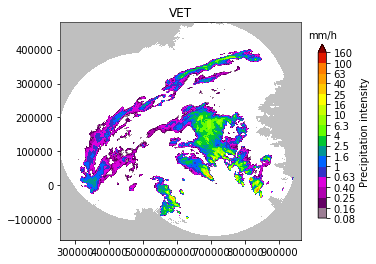

In [9]:
oflow_method = motion.get_method("VET")
V2 = oflow_method(R[-3:, :, :])

# Plot the motion field
plot_precip_field(R_, geodata=metadata, title="VET")
quiver(V2, geodata=metadata, step=25)
plt.show()

###动态和自适应雷达风暴跟踪（DARTS）
DARTS使用光谱方法处理光流，该方法基于雷达场的时间序列的离散傅立叶变换（DFT）。DFT系数的截断级别控制着估计的运动场的平滑度，从而可以进行有效的运动估计。DARTS需要更长的雷达场序列来估计运动，这里我们将使用所有可用的10个场。

Computing the motion field with the DARTS method.
-----
DARTS
-----
  Computing the FFT of the reflectivity fields...
Done in 0.36 seconds.
  Constructing the y-vector...
Done in 0.36 seconds.
  Constructing the H-matrix...
Done in 1.35 seconds.
  Solving the linear systems...
Done in 0.25 seconds.
--- 2.424975633621216 seconds ---


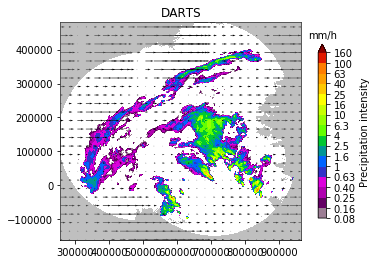

In [10]:
oflow_method = motion.get_method("DARTS")
R[~np.isfinite(R)] = metadata["zerovalue"]
V3 = oflow_method(R)  # needs longer training sequence

# Plot the motion field
plot_precip_field(R_, geodata=metadata, title="DARTS")
quiver(V3, geodata=metadata, step=25)
plt.show()

### 各向异性扩散法（Proesmans et al 1994）
该模块实现了Proesmans等人提出的各向异性扩散方法。（1994），一种健壮的光流技术，在求解光流方程时采用了不一致的概念。

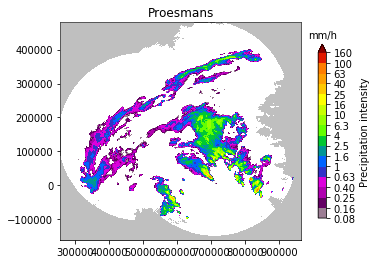

In [11]:
oflow_method = motion.get_method("proesmans")
R[~np.isfinite(R)] = metadata["zerovalue"]
V4 = oflow_method(R[-2:, :, :])

# Plot the motion field
plot_precip_field(R_, geodata=metadata, title="Proesmans")
quiver(V4, geodata=metadata, step=25)
plt.show()

# sphinx_gallery_thumbnail_number = 1